In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import statsmodels.formula.api as smf
# import statsmodels.tsa.api as smt
import statsmodels.api as sm
# import scipy.stats as scs

from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
# from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import timedelta

%matplotlib inline

# Урок 2. Кейс 1. Преобразование признаков.

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза, на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

**1. Прочитайте базу "Потребление Энергии" и сделайте модель основных изменений по data_exp_1(сглаженной) с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти".**

In [3]:
data = pd.read_csv('./datasets/my_DUQ_hourly.csv', index_col=[0], parse_dates=[0])

data.head()

,DUQ_MW
Datetime,
2005-01-01 01:00:00,1364.0
2005-01-01 02:00:00,1273.0
2005-01-01 03:00:00,1218.0
2005-01-01 04:00:00,1170.0
2005-01-01 05:00:00,1166.0


In [4]:
data.describe()

,DUQ_MW
count,119088.000000
mean,1658.771320
std,301.741752
min,1014.000000
25%,1444.000000
50%,1630.000000
75%,1819.000000
max,3054.000000


В предыдущем уроке мы избавились от всех пропусков в данных. В этом уроке наша цель построить как можно больбше эндогенных признаков. Признак будет считаться хорошим, если его добавка до исходного ряда является стационарным рядом. В таком случае можно прогнозировать исходную величину как сумму фактора и нормально-распределённой добавки $N(\mu, \sigma)$ по известному матожиданию и дисперсии этой добавки.

Построим эксчпоненциально сглаженный признак с параметром $\alpha = 0.05$, и построим модель по этому признаку.

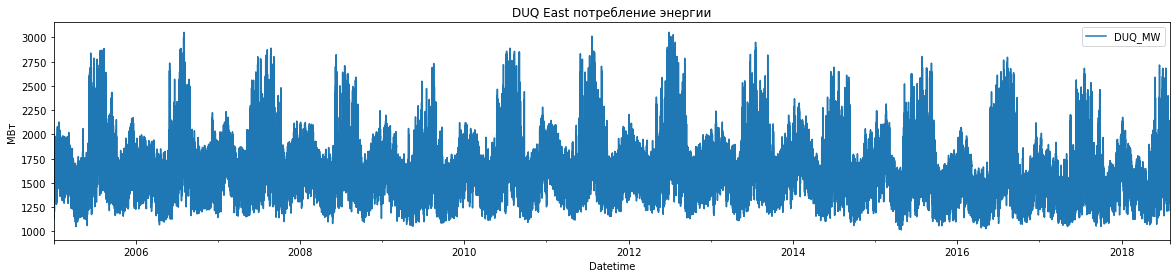

In [5]:
data.plot(style='-', figsize=(20,4))
plt.title('DUQ East потребление энергии')
plt.ylabel('МВт')
plt.show()

In [6]:
# экспоненциальное сглаживание
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return np.array(result)

In [7]:
data_exp_005 = exponential_smoothing(data['DUQ_MW'], 0.05)

In [10]:
diff = data['DUQ_MW'] - data_exp_005
sm.tsa.stattools.adfuller(diff.values[:10000], regression='ct')

(-15.593550059828065,
 1.3139379027552057e-22,
 37,
 9962,
 {'1%': -3.959679049889144,
  '5%': -3.4109308058124856,
  '10%': -3.1273095858484945},
 95784.16843294454)

По критерию Дики-Фулера добавка является стационарным рядом.

In [11]:
a = diff.mean()
sigma = diff.std(ddof=1)
print(f'Параметры распределения разности сглаженных значений и исходных.\n\tМат-ожидание:\t{a}\n\tДисперсия:\t{sigma}')

Параметры распределения разности сглаженных значений и исходных.
	Мат-ожидание:	0.06862972440120214
	Дисперсия:	208.4124028057933


In [12]:
data['smoothed'] = data_exp_005

data.head()

,DUQ_MW,smoothed
Datetime,,
2005-01-01 01:00:00,1364.0,1364.000000
2005-01-01 02:00:00,1273.0,1359.450000
2005-01-01 03:00:00,1218.0,1352.377500
2005-01-01 04:00:00,1170.0,1343.258625
2005-01-01 05:00:00,1166.0,1334.395694


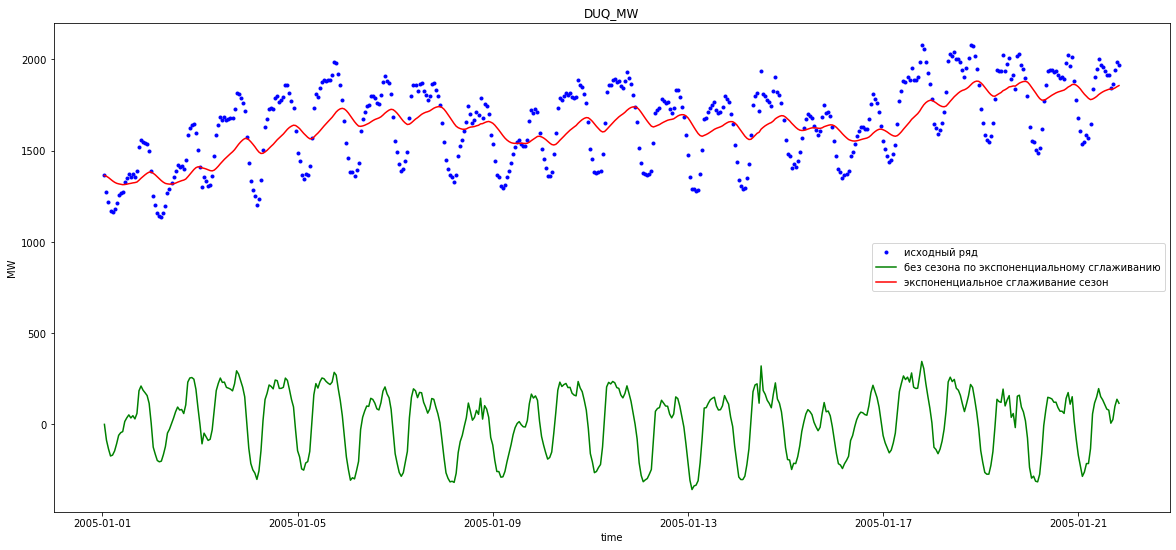

In [13]:
sample_size = 500
plt.figure(figsize=(20, 9))

plt.plot(data.index[:sample_size], data['DUQ_MW'].values[:sample_size], '.b', label='исходный ряд')

plt.plot(data.index[:sample_size], data['DUQ_MW'].values[:sample_size] - data['smoothed'].values[:sample_size] , '-g', label="без сезона по экспоненциальному сглаживанию")

plt.plot(data.index[:sample_size], data['smoothed'].values[:sample_size] , '-r', label="экспоненциальное сглаживание сезон")

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('DUQ_MW')
plt.show()

In [14]:
# добавим историю на глубину в три измерения от текущего (р=3)

p = 3
for i in range(p):
    offset = i + 1
    data[f't_{offset}'] = 0
    data[f't_{offset}'][offset:] = data['smoothed'][:-offset]

In [15]:
# добавили сглаживание (3 вида - просто для коллекции)

data['exp_0_01'] = exponential_smoothing(data['smoothed'], 0.01)
data['exp_0_03'] = exponential_smoothing(data['smoothed'], 0.03)
data['exp_0_08'] = exponential_smoothing(data['smoothed'], 0.08)

In [16]:
# добавим разности - первый и второй порядки.

data['diff1'] = data['smoothed'].diff(1)
data['diff2'] = data['smoothed'].diff(1).diff(1)

In [17]:
# добавим признаки дня недели и месяца.

data['year'] = data.index.year
data['month'] = data.index.month
data['quarter'] = data.index.quarter
data['dayofweek'] = data.index.dayofweek
data['dayofmonth'] = data.index.day
data['dayofyear'] = data.index.dayofyear
data['weekofyear'] = data.index.weekofyear

In [18]:
# Эндогенные признаки не добавляем.

# добавим признаки выходных и праздников

# one_day = timedelta(days=1)
# cal = calendar()

# data['is_holiday'] = data.index.isin([d.date() for d in cal.holidays()]).astype('uint8')
# data['is_prev_holiday'] = data.index.isin([( d.date() - one_day ) for d in cal.holidays()]).astype('uint8')
# data['is_next_holiday'] = data.index.isin([( d.date() + one_day ) for d in cal.holidays()]).astype('uint8')

In [19]:
# добавим скользящее среднее за 24 часа.

window_size = 24

data[f'window_{window_size}'] = data['smoothed'].rolling(window=window_size).mean()

In [20]:
data.head()

,DUQ_MW,smoothed,t_1,t_2,t_3,exp_0_01,exp_0_03,exp_0_08,diff1,diff2,year,month,quarter,dayofweek,dayofmonth,dayofyear,weekofyear,window_24
Datetime,,,,,,,,,,,,,,,,,,
2005-01-01 01:00:00,1364.0,1364.000000,0.000000,0.0000,0.00,1364.000000,1364.000000,1364.000000,NaN,NaN,2005,1,1,5,1,1,53,NaN
2005-01-01 02:00:00,1273.0,1359.450000,1364.000000,0.0000,0.00,1363.954500,1363.863500,1363.636000,-4.550000,NaN,2005,1,1,5,1,1,53,NaN
2005-01-01 03:00:00,1218.0,1352.377500,1359.450000,1364.0000,0.00,1363.838730,1363.518920,1362.735320,-7.072500,-2.522500,2005,1,1,5,1,1,53,NaN
2005-01-01 04:00:00,1170.0,1343.258625,1352.377500,1359.4500,1364.00,1363.632929,1362.911111,1361.177184,-9.118875,-2.046375,2005,1,1,5,1,1,53,NaN
2005-01-01 05:00:00,1166.0,1334.395694,1343.258625,1352.3775,1359.45,1363.340557,1362.055649,1359.034665,-8.862931,0.255944,2005,1,1,5,1,1,53,NaN


In [21]:
# разбиение на тестовую и тренировочную выборку 
def split_data(data, split_date):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

In [22]:
# метрика качества - средняя процентная ошибка
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Разобьём выборку на тренировочную и тестовую. Здесь отбрасываем 23 первых измерения. При прогнозировании глубина истории $p = 3$, а размер скользящего окна $N = 24$.

In [23]:
train, test = split_data(data[window_size-1:], '01-01-2016')

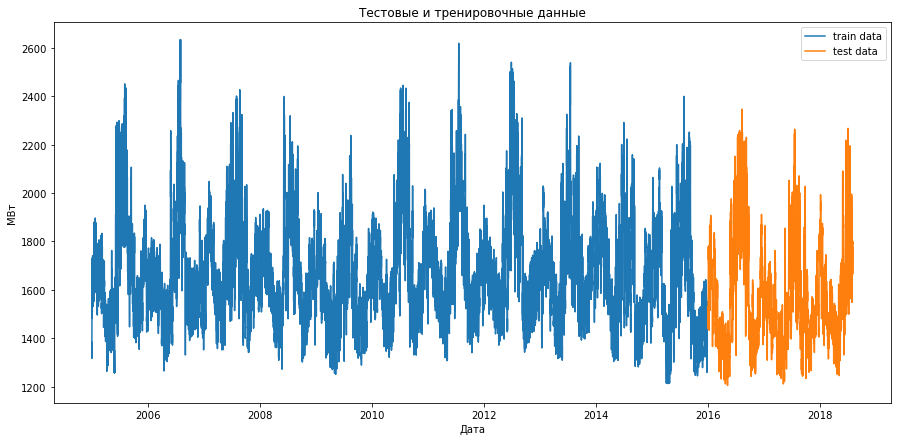

In [24]:
plt.figure( figsize=(15, 7))
plt.plot(train.index, train['smoothed'], label='train data' )
plt.plot(test.index, test['smoothed'], label='test data')

plt.xlabel('Дата')
plt.ylabel('МВт')
plt.title('Тестовые и тренировочные данные')
plt.legend()
plt.show()

Далее строим модель.

In [27]:
model = GradientBoostingRegressor(max_depth=15, random_state=42, n_estimators=100)

In [28]:
# горизонт предсказания
h = 1

X_train = train.iloc[:-h,:].drop(columns=['DUQ_MW', 'smoothed'])
y_train = train['smoothed'].values[h:]
X_test = test.iloc[:-h,:].drop(columns=['DUQ_MW', 'smoothed'])
y_test = test['smoothed'].values[h:]

In [29]:
# обучение модели
model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=15, random_state=42)

In [30]:
# предсказание
y_test_pred = model.predict(X_test)

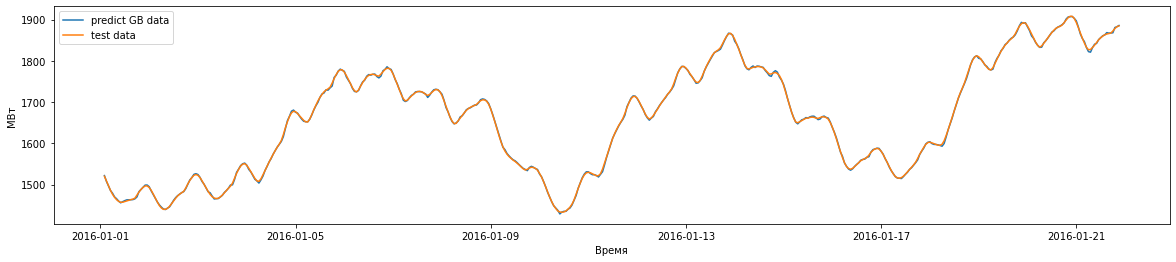

In [31]:
sample_size = 500
plt.figure(figsize=(20, 4))
plt.xlabel('Время')
plt.ylabel('МВт')

plt.plot(test.index[h:sample_size+h], y_test_pred[:sample_size], label='predict GB data')
plt.plot(test.index[h:sample_size+h], y_test[:sample_size], label='test data')

plt.legend()
plt.show()

In [32]:
error = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)

print(f'Ошибка градиентного бустинга при h={h}: {error}%')

Ошибка градиентного бустинга при h=1: 0.11663760832068529%


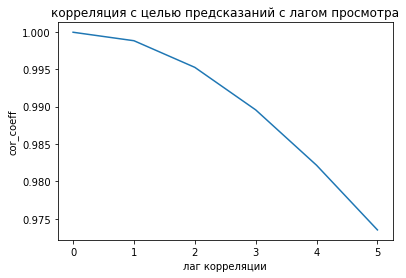

In [33]:
lag = 5
p_cor = [np.corrcoef(y_test, y_test_pred)[1,0]]
for i in range(lag):
    c = np.corrcoef(y_test[:-(i+1)], y_test_pred[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) ) 
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

In [34]:
# горизонт предсказания
h = 10

X_train = train.iloc[:-h,:].drop(columns=['DUQ_MW', 'smoothed'])
y_train = train['smoothed'].values[h:]
X_test = test.iloc[:-h,:].drop(columns=['DUQ_MW', 'smoothed'])
y_test = test['smoothed'].values[h:]

In [35]:
# обучение модели
model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=15, random_state=42)

In [36]:
# предсказание
y_test_pred = model.predict(X_test)

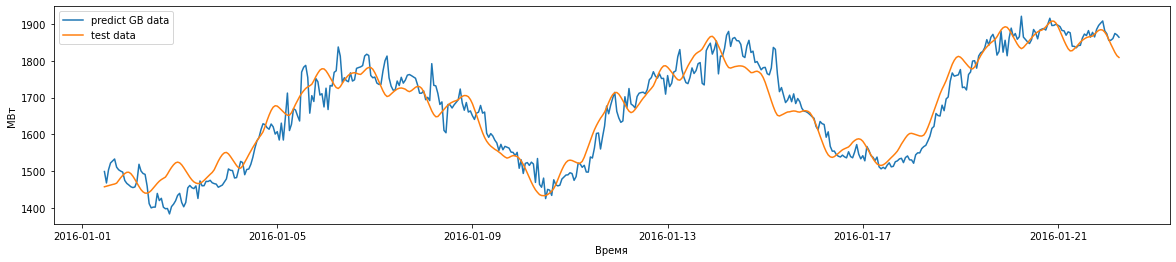

In [37]:
sample_size = 500
plt.figure(figsize=(20, 4))
plt.xlabel('Время')
plt.ylabel('МВт')

plt.plot(test.index[h:sample_size+h], y_test_pred[:sample_size], label='predict GB data')
plt.plot(test.index[h:sample_size+h], y_test[:sample_size], label='test data')

plt.legend()
plt.show()

In [38]:
error = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)

print(f'Ошибка градиентного бустинга при h={h}: {error}%')

Ошибка градиентного бустинга при h=10: 2.238219143544805%


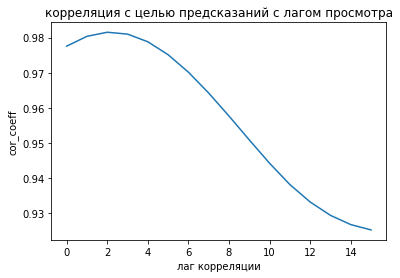

In [39]:
lag = 15
p_cor = [np.corrcoef(y_test, y_test_pred)[1,0]]
for i in range(lag):
    c = np.corrcoef(y_test[:-(i+1)], y_test_pred[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) ) 
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

**2. Оцените ошибку модели из п.1.**

При $h = 1$ ошибка составила $0.12\%$.

При $h = 10$ ошибка составила $2.24\%$.

**3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.**

Чем больше горизонт предсказания, тем больше ошибка. При прогнозировании по сглаженным данным ошибка значительно меньше, чем при прогнозирвоании по исходной выборке (тут в отчете нет прогноза, но получались цифры около 1% и 7%).

**4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):**

    а) Изменение температуры за окном :).

Этот ряд не стационарный, так как есть циклическая составляющая. У ряда есть тренд из-за глобального потепления. Ряд с сезонностью в одни сутки и циклом в один год.

    б) Количество денег, которые тратят покупатели в интернет магазине.

Этот ряд не стационарный, так как есть циклическая составляющая. У ряда есть тренд из-за инфляции. Ряд с сезонностью в один месяц и циклом в один год. Явные признаки цикличности - в декабре траты увеличиваются, в январе уменьшаются.

    в) Вес растущего котенка.

С детализацией по дням у этого ряда будет тренд, но не будет циклической и сезонной составляющей. Из-за тренда ряд нельзя назвать стационарным.

    г) Прирост объема деревьев в лесу от времени

Так же как и с котёнком, у ряда будет тренд. Скорее всего будет сезонная составляющая, так как летом деревья растут быстрее.